In [19]:
import xarray as xr
import numpy as np
import yaml
import xesmf
import matplotlib.pyplot as plt

### Load PRISM

In [11]:
from ftplib import FTP
import os
from tqdm import tqdm, trange
import re
from zipfile import ZipFile

In [16]:
def download_prism(dst, variable, years=(1981, 2023)):
    os.makedirs(dst, exist_ok=True)
    ftp = FTP("prism.oregonstate.edu")
    ftp.login()
    for year in trange(*years):
        ftp.cwd(f"/daily/{variable}/{year}")
        for remote_fn in tqdm(ftp.nlst(), leave=False):
            local_fn = os.path.join(dst, remote_fn)
            with open(local_fn, "wb") as file:
                ftp.retrbinary(f"RETR {remote_fn}", file.write)
            subdir_name = re.search(r"\d{8}", remote_fn)[0]
            subdir_path = os.path.join(dst, subdir_name)
            os.makedirs(subdir_path, exist_ok=True)
            with ZipFile(local_fn) as myzip:
                myzip.extractall(path=subdir_path)
            os.unlink(local_fn)
    ftp.quit()

In [17]:
download_prism("/app/data/raw/prism", "tmax", years=(1981, 1982))

100%|██████████| 1/1 [34:31<00:00, 2071.71s/it]


### Open data

In [20]:
# Get eobs bounds
with open("/app/configs/load/era.yaml", 'r') as file:
    cfg = yaml.safe_load(file)
TOP = cfg["eobs_bounds"]["top"]
BOTTOM = cfg["eobs_bounds"]["bottom"]
LEFT = cfg["eobs_bounds"]["left"]
RIGHT = cfg["eobs_bounds"]["right"]

In [74]:
# Open the NetCDF file
ds_eobs = xr.open_dataset('/app/data/raw/era5-eobs/e-obs/ensemble_mean/025_grid/1950-2023/tg_v28.0e.nc').sel(time=slice("1960-01-01", "1960-12-31"))
ds_eobs = ds_eobs.sel(latitude=slice(BOTTOM,TOP), longitude=slice(LEFT,RIGHT))
ds_era = xr.open_mfdataset('/app/data/raw/era5-eobs/era5_0.25_D/2m_temperature/*.zarr', engine="zarr").sel(time=slice("1960-01-01", "1960-12-31"))


In [22]:
# Print minimum and maximum latitude and longitude
min_lon, max_lon = ds_era.longitude.min().values, ds_era.longitude.max().values
min_lat, max_lat = ds_era.latitude.min().values, ds_era.latitude.max().values
print("Minimum Longitude:", min_lon)
print("Maximum Longitude:", max_lon)
print("Minimum Latitude:", min_lat)
print("Maximum Latitude:", max_lat)

# Print resolution
resolution_lon = abs(ds_era.longitude[1] - ds_era.longitude[0])
resolution_lat = abs(ds_era.latitude[1] - ds_era.latitude[0])
print("Longitude Resolution:", resolution_lon)
print("Latitude Resolution:", resolution_lat)

# Calculate time step in days
time_step = np.timedelta64(ds_era.time[1].values - ds_era.time[0].values, 'D')
print("Time Step (days):", time_step)

# Close the ds_era
ds_era.close()

Minimum Longitude: -15.0
Maximum Longitude: 40.0
Minimum Latitude: 35.0
Maximum Latitude: 71.0
Longitude Resolution: <xarray.DataArray 'longitude' ()>
array(0.25, dtype=float32)
Latitude Resolution: <xarray.DataArray 'latitude' ()>
array(0.25, dtype=float32)
Time Step (days): 1 days


### EOBS Interpolation and ERA mask

In [75]:
ds_eobs['tg'] = ds_eobs['tg'] +273.15

In [76]:
regridder = xesmf.Regridder(ds_eobs,
                            ds_era,
                            # {"lat": ds_era.latitude, "lon": ds_era.longitude},
                            "conservative_normed",
                            periodic=False
                            )

In [77]:
ds_eobs_regr = regridder(ds_eobs, keep_attrs=True)

In [78]:
mask_global=1
# Create mask for E-OBS dataset to exclude NaNs
inp = ds_eobs_regr
for k in ["tg"]:#, "tx", "tn", "rr"]:
    mask = ~np.isnan(inp[k]).any(axis=0)*1
    mask_global = (mask_global == 1) & (mask == 1)
    mask_global = mask_global*1

# Save mask
# np.save(os.path.join(src_dir, "mask.npy"), mask_global)
ds_era_land=ds_era.where(mask_global, drop=True)

In [86]:
ds = xr.Dataset(
    # data_vars=dict(
    #     temperature=(["loc", "instrument", "time"], temperature),
    #     precipitation=(["loc", "instrument", "time"], precipitation),
    # ),
    coords=dict(
        lon=(["lon"], ds_era.longitude.values),
        lat=(["lat"], ds_era.latitude.values),
        # instrument=instruments,
        # time=time,
        # reference_time=reference_time,
    ))

### Plots

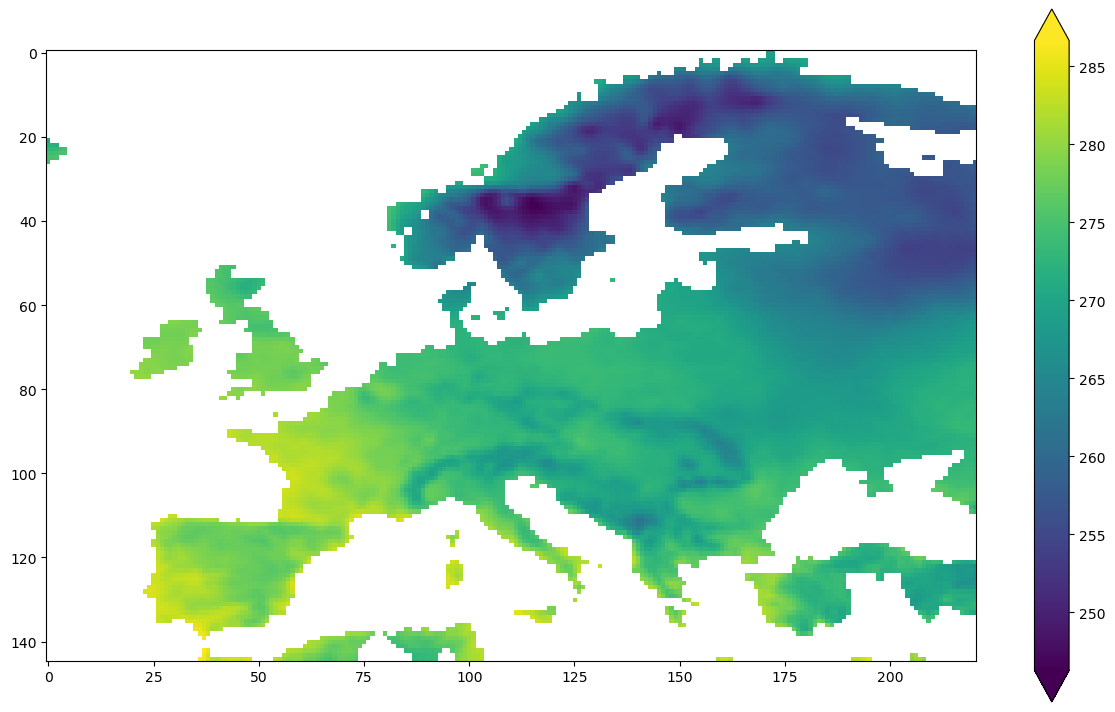

In [79]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_eobs_regr['tg'][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )

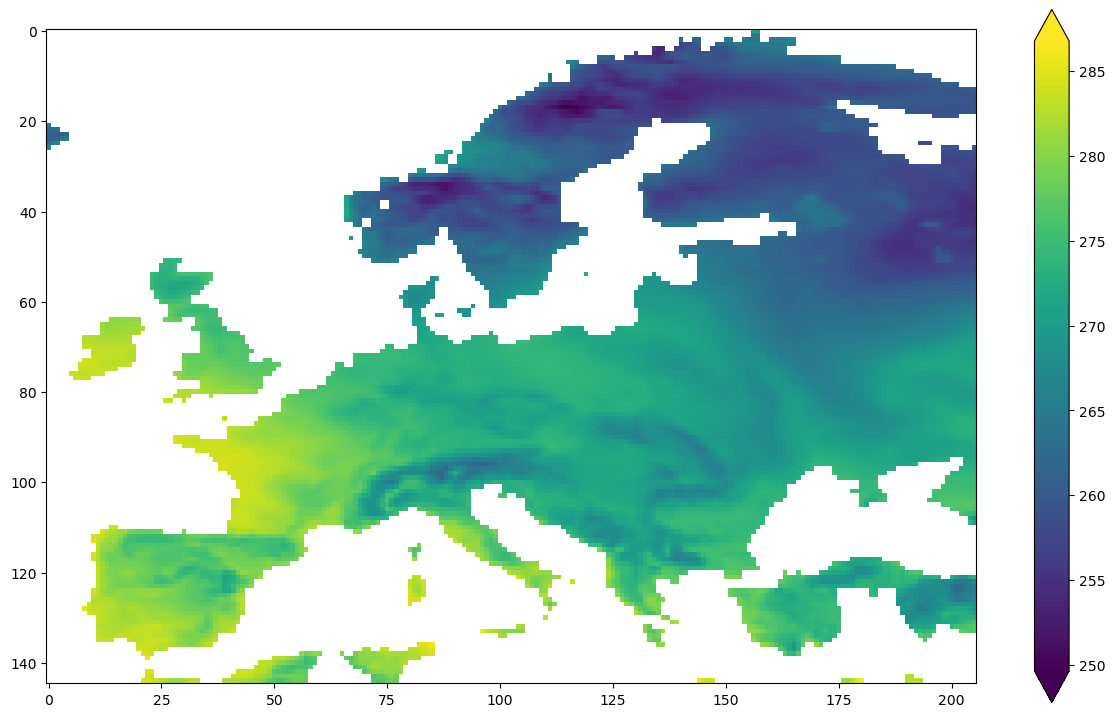

In [80]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_era_land["2m_temperature"][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )

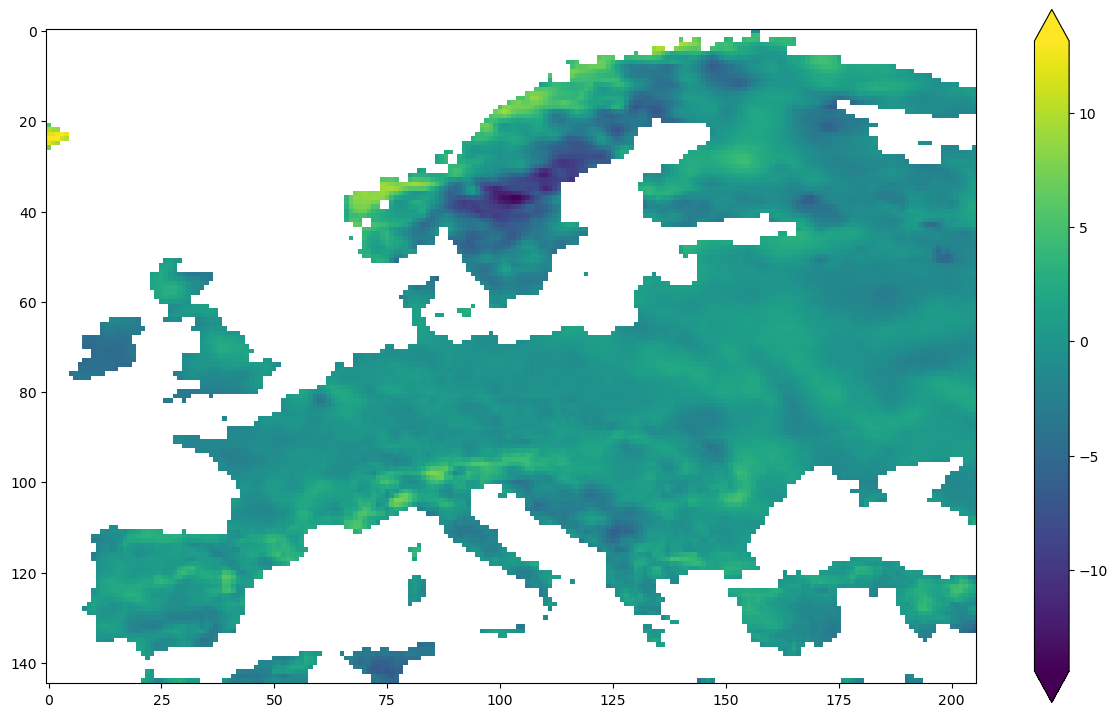

In [81]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_eobs_regr['tg'][20, :, :] - ds_era_land["2m_temperature"][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )

### Plots with 0 instead of NANs

In [60]:
# ds_eobs_with_zero = ds_eobs.fillna(0)

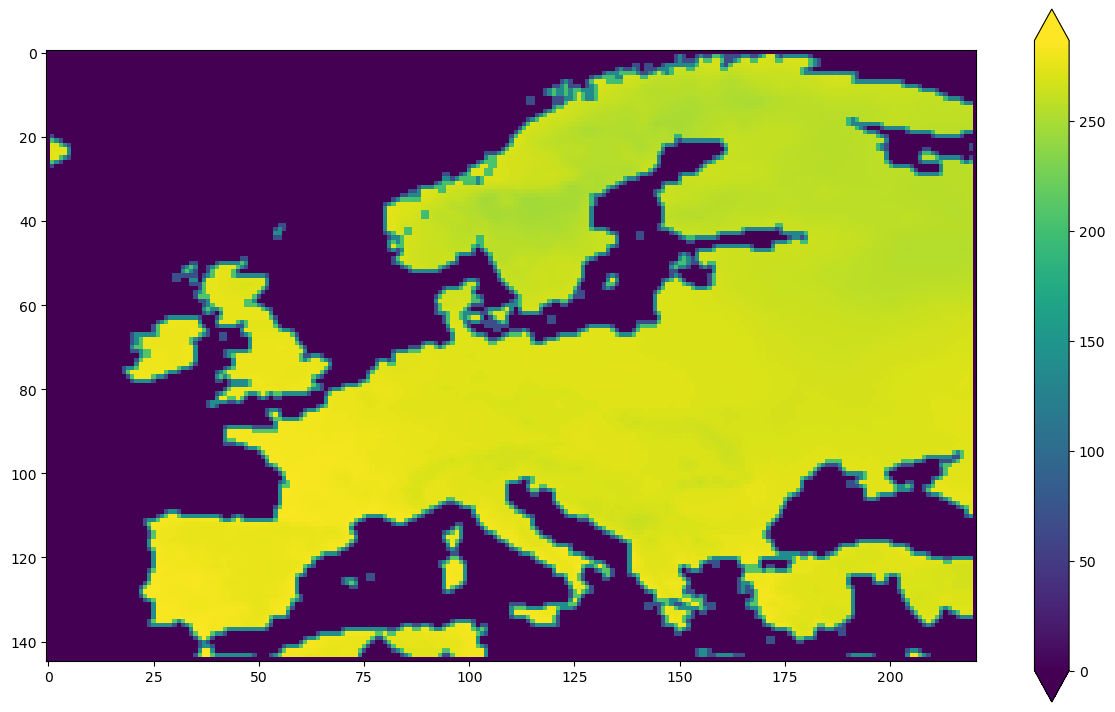

In [66]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_eobs_regr['tg'][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )

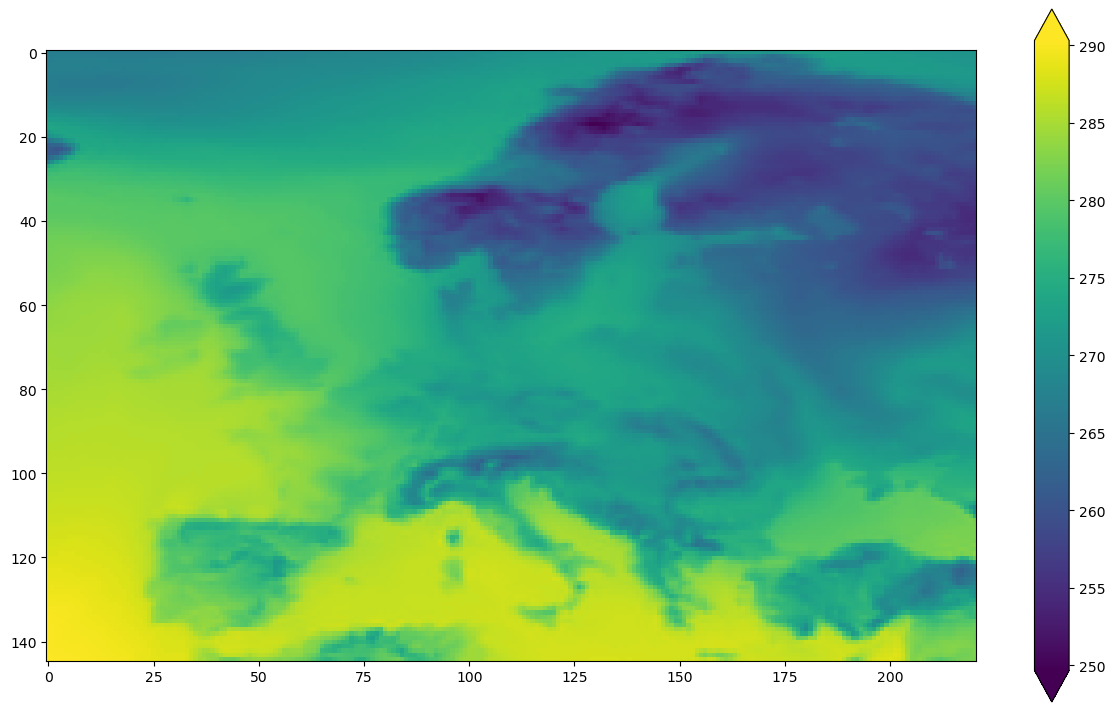

In [68]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_era["2m_temperature"][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )

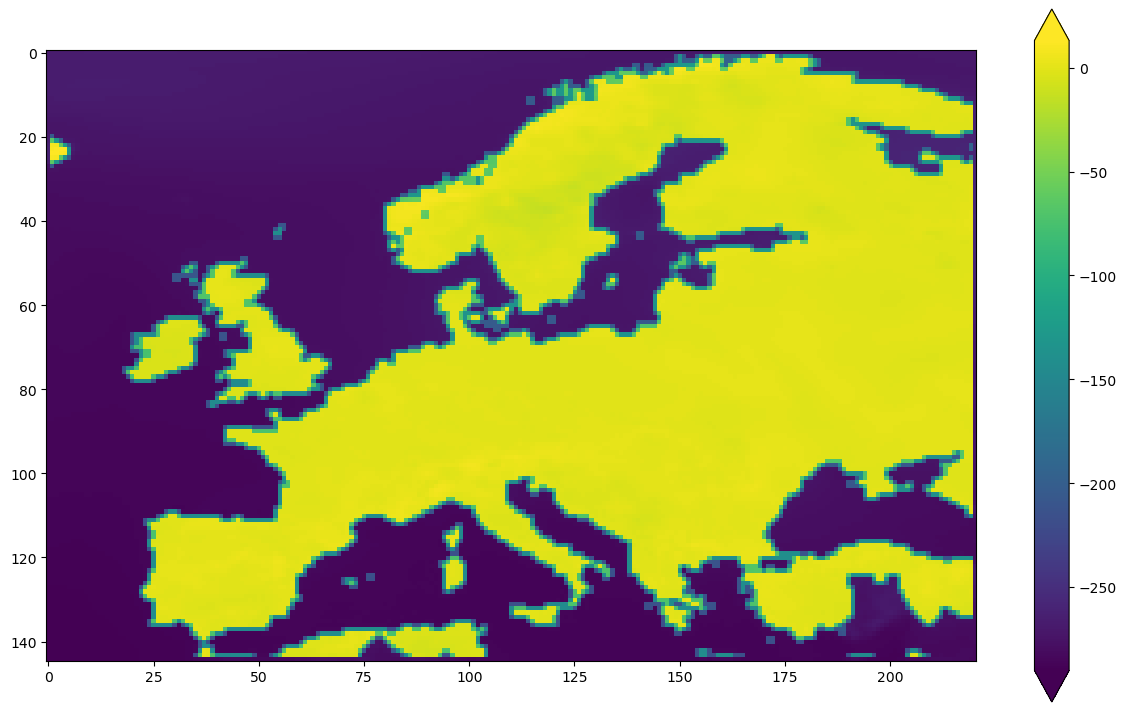

In [69]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(15, 10))
im= ax1.imshow(ds_eobs_regr['tg'][20, :, :] - ds_era["2m_temperature"][20, :, :],
            #    origin="lower"
               )
cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=ax1 )